## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import preprocessing as preprocess
import grouping as group
import spliting as split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager
plt.rcParams['axes.unicode_minus'] = False
# plt.figure(figsize=(10, 5))

import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost


# font_path = 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf' #한글 폰트 경로 
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' #한글 폰트 경로 

font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
#MAPE definition
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Data Load and Preprocessing

`preprocessing.py`와 `grouping.py`에 전처리 코드를 넣어 원본데이터가 한번에 전처리되어 출력되도록 했습니다. 주요 전처리 내용은 다음과 같습니다. <br><br>

**1. 종속변수(취급액) 가공**

예측의 대상인 취급액은 판매단가에 판매량을 곱한 값으로 상품마다 scale의 차이가 큽니다. 따라서 취급액을 판매단가로 나눈 판매량이라는 변수를 새로 만들어 이를 예측하는 것이 유리합니다. 그리고 판매량의 분포가 양의 왜도를 가짐을 확인하고 이를 정규화하기 위해 로그 변환을 해주어 `log_sales_cnt`라는 변수를 생성했습니다.

**2. 파생변수 생성**

제공된 데이터의 변수는 8개입니다. 좋은 성능의 모델을 만들기 위해서는 유의미한 변수의 도출이 필수적입니다. EDA를 통해 변수의 특성을 파악하고 FE를 진행했습니다. 방송일시 변수를 연, 월, 일, 시, 분, 요일 등으로 나누고 공휴일 변수를 추가했습니다. 이외에도 다양한 변수를 가공해 `order_grp`나 `unit_price_group`등의 변수를 생성했습니다.

**3. 외부변수 채택**

주어진 변수 이외에도 판매량에 영향을 미칠 수 있는 외부변수를 채택했습니다. [기상자료개방포털](https://data.kma.go.kr/cmmn/main.do)에서 시각별 기온, 강수량, 습도 등의 기상정보를 가져왔고 [통계청](http://kostat.go.kr/portal/korea/index.action)에서 소비자 물가지수와 소비자 동향지수 데이터를 가져왔습니다. 이외에도 검색어 데이터, 뉴스 데이터도 고려했으나 양질의 데이터 획득의 어려움과 비상관성을 이유로 채택하지 않았습니다.

In [3]:
""""Directory
bigcon 
  |- data
       |- 01_제공데이터
       |- 02_평가데이터
       |- 03_제출데이터
  |- source
"""
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
source_dir = os.path.join(cur_dir, 'source')
data_train_dir = os.path.join(data_dir, '01_제공데이터')
data_test_dir = os.path.join(data_dir, '02_평가데이터')
data_submit_dir = os.path.join(data_dir, '03_제출데이터')


""" Parameters
"""
headline = '2020 빅콘테스트 데이터분석분야-챔피언리그'
train_target = '2019년 실적데이터'
test_target = '2020년 6월 판매실적예측데이터(평가데이터)'
rate_target = '시청률 데이터'


""" Load Data
"""
dfs = preprocess.ProcessSale(
    data_dir = data_dir,
    source_dir = source_dir,
    data_train_dir = data_train_dir,
    data_test_dir = data_test_dir,
    headline = headline,
    train_target = train_target,
    rate_target = rate_target,
    test_target = test_target,
)

df_train = dfs.train_preprocess()
df_test = dfs.test_preprocess()
df_rate = dfs.rate_preprocess()

Grouping = group.Grouping(df_train, df_test)
df_train = Grouping.make_train()
df_test = Grouping.make_test()

Train : file already exist!
Test : file already exist!


In [4]:
print(df_train.shape) #제공데이터
print(df_test.shape)  #평가데이터

(35379, 32)
(2891, 32)


최종적으로, 전처리 된 컬럼은 다음과 같습니다.

#### 기존변수
  * **datetime** - 방송일시입니다.
  * **exposure(min)** - 상품이 방송에 노출된 시간입니다.
  * **mother_cd** - 상품의 마더코드입니다.
  * **product_cd** - 상품의 상품코드입니다.
  * **product_name** - 상품명입니다.
  * **product_grp** - 상품군입니다.
  * **unit_price** - 상품의 개당 판매단가입니다. 
  * **sell_price** - 상품의 총 판매액, 즉 취급액입니다.
 
#### 파생변수
  * **sales_cnt** -  판매량입니다. 상품의 취급액을 판매단가로 나누어 계산합니다.
  * **log_sales_cnt** -  판매량에 로그를 취한 값입니다. 종속변수의 분포를 정규화하기 위함입니다.
  * **group** - 판매량과 판매단가의 특성을 고려해 설정한 상품의 그룹입니다. 추후 해당 그룹별로 모델링을 진행합니다.
  * **unit_price_group** - 각 그룹별 판매단가의 정도입니다. 각 그룹 기준 33% 미만은 chaep, 33%이상 66%미만은 medium, 나머지는 expensive입니다.
  
  * **year** - 방송일시에서 파생된 변수입니다. 방송된 연도입니다. 
  * **month** - 방송일시에서 파생된 변수입니다. 방송된 월입니다
  * **day** - 방송일시에서 파생된 변수입니다. 방송된 일자입니다
  * **hour** - 방송일시에서 파생된 변수입니다. 방송된 시각입니다
  * **minute** - 방송일시에서 파생된 변수입니다. 방송된 분입니다
  * **weekday** - 방송일시에서 파생된 변수입니다. 방송된 요일입니다
  * **holiday** - 공휴일입니다. 2019년 및 2020년 법정공휴일과 주말은 1, 나머지는 0입니다.
  * **month_order** - 월초, 월중, 월말을 나타내는 변수입니다. 
  * **order_grp** - 같은 상품이 연속적으로 방송되었을 경우의 순서정보입니다. 방송일시와 마더코드를 기준으로 생성했습니다. 시작, 중간, 마지막으로 이루어져있습니다.
  
#### 외부변수
  * **temp** - 방송된 시각의 기온(°C)입니다. 
  * **rainfall** - 방송된 시각의 강수량(mm)입니다. 
  * **wind_speed** - 방송된 시각의 풍속(m/s)입니다.
  * **wind_direction** - 방송된 시각의 풍향(16방위)입니다.
  * **humidity** - 방송된 시각의 습도(%)입니다.
  * **pressure** - 방송된 시각의 증기압(hPa)입니다.
  * **spot_pressure** - 방송된 시각의 현지기압(hPa)입니다..
  * **sea_level_pressure** - 방송된 시각의 해면기압(hPa)입니다.
  * **snowfall** - 방송된 시각의 적설량(cm)입니다.
  
  * **cpi** - 방송된 월의 소비자 물가지수입니다.
  * **csi** - 방송된 월의 소비자 동향지수입니다.
  
  
#### 외부변수 출처
기상자료개방포털 : [https://data.kma.go.kr/cmmn/main.do](https://data.kma.go.kr/cmmn/main.do)<br>
통계청 : [http://kostat.go.kr/portal/korea/index.action](http://kostat.go.kr/portal/korea/index.action)

In [5]:
df_train.head()

,datetime,year,month,day,hour,minute,weekday,holiday,month_order,order_grp,exposure(min),mother_cd,product_cd,product_name,product_grp,temp,rainfall,wind_speed,wind_direction,humidity,pressure,spot_pressure,sea_level_pressure,snowfall,unit_price,sell_price,sales_cnt,group,unit_price_group,cpi,csi,log_sales_cnt
0,2019-01-01 06:00:00,2019,1,1,6,0,Tuesday,1,초,시작,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,2099000.0,52.606516,group4,cheap,100.8,97.5,3.962840
1,2019-01-01 06:00:00,2019,1,1,6,0,Tuesday,1,초,시작,20.0,100346,201079,테이트 여성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,4371000.0,109.548872,group4,cheap,100.8,97.5,4.696371
2,2019-01-01 06:20:00,2019,1,1,6,20,Tuesday,1,초,중간,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,3262000.0,81.754386,group4,cheap,100.8,97.5,4.403719
3,2019-01-01 06:20:00,2019,1,1,6,20,Tuesday,1,초,중간,20.0,100346,201079,테이트 여성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,6955000.0,174.310777,group4,cheap,100.8,97.5,5.160840
4,2019-01-01 06:40:00,2019,1,1,6,40,Tuesday,1,초,마지막,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,6672000.0,167.218045,group4,cheap,100.8,97.5,5.119299


추후의 모델링을 위해 범주형변수의 형식을 'category'로 변경해줍니다.

In [6]:
col = ['month','weekday','month_order','order_grp','product_grp','unit_price_group']

In [7]:
for i in col : 
    df_train[i] = df_train[i].astype('category') 
    df_test[i] = df_test[i].astype('category')

## EDA

변수별 EDA 자료와 코드는 첨부된 ipynb파일에 있으며, 주요 내용은 결과보고서에 시각화 자료를 첨부합니다.


#### 예시

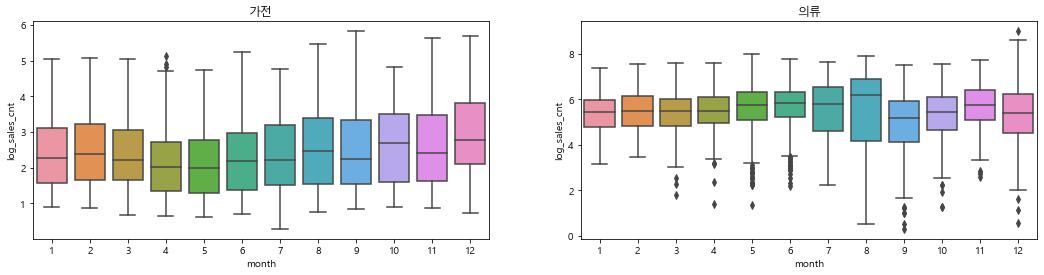

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)
sns.boxplot(data=df_train[df_train.product_grp=='가전'], x='month', y='log_sales_cnt', ax=ax1).set_title('가전') 
sns.boxplot(data=df_train[df_train.product_grp=='의류'], x='month', y='log_sales_cnt', ax=ax2).set_title('의류') 
plt.show()

* EDA_weather.ipynb
* EDA_time.ipynb
* EDA_Group.ipynb
* EDA_all.ipynb

## Variable Selection and Grouping

변수선택과 Grouping, 범주형변수 더미화는 `spliting.py`로 처리했습니다. 해당 클래스의 `return_g`라는 함수는 전처리된 데이터프레임 `df_train`을 받아 정해진 변수에 대해 Grouping과 더미화를 하고 네 개의 데이터프레임을 출력합니다.

#### Variable Selection
EDA를 통해 선택된 유의미한 변수는 다음과 같습니다.

`month`, `hour`, `minute`, `weekday`, `holiday`, `month_order`, `order_grp`, `exposure(min)`, `mother_cd`, `product_grp`, `temp`, `humidity`, `unit_price`, `unit_price_group`, `cpi`, `csi`  
<br>
학습에 사용될 종속변수는 `log_sales_cnt`입니다.

#### Grouping
그룹은 모델의 성능 상승을 위해 생성했습니다. 상품군 별 판매량과 판매단가의 분포를 확인하고 각 상품군 간 상관관계를 고려하여 그룹을 만들었습니다. 해당 그룹별로 약간의 변수 조정이 있을 수 있으며 추후 다른 모델이 각각 적용될 수 있습니다.
 * Group 1 : 가구, 가전<br>
 * Group 2 : 농수축, 이미용<br>
 * Group 3 : 생활용품, 주방, 잡화<br>
 * Group 4 : 건강기능, 속옷, 의류, 침구<br><br>
 
그룹 구성에 관련한 분포 시각화 및 상관관계 정보는 별도의 파일로 첨부합니다.
 * Grouping.ipynb

In [9]:
Spliting = split.Spliting()
g1, g2, g3, g4 = Spliting.return_g(df_train)

In [10]:
print(g1.shape) #group1
print(g2.shape) #group2
print(g3.shape) #group3
print(g4.shape) #group4

(7465, 30)
(5189, 17)
(13034, 17)
(9691, 17)


## Train Test Split

각 그룹별 모델링을 진행하기 위해 X와 y로 변수를 나눠주고, 각각을 Train Set과 Test Set으로 나눠줍니다.

In [11]:
X1, y1 = g1.drop('log_sales_cnt', axis=1), g1['log_sales_cnt']
X2, y2 = g2.drop('log_sales_cnt', axis=1), g2['log_sales_cnt']
X3, y3 = g3.drop('log_sales_cnt', axis=1), g3['log_sales_cnt']
X4, y4 = g4.drop('log_sales_cnt', axis=1), g4['log_sales_cnt']

In [12]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [13]:
print(X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape)
print(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)
print(X3_train.shape, y3_train.shape, X3_test.shape, y3_test.shape)
print(X4_train.shape, y4_train.shape, X4_test.shape, y4_test.shape)

(5225, 29) (5225,) (2240, 29) (2240,)
(3632, 16) (3632,) (1557, 16) (1557,)
(9123, 16) (9123,) (3911, 16) (3911,)
(6783, 16) (6783,) (2908, 16) (2908,)


## Modeling

모델링은 각 그룹별로 여러 개의 머신러닝 및 딥러닝 기법을 시도하여 Best Score를 갖는 모델을 채택했습니다.<br><br>
시도한 모델은 다음과 같습니다.

 * Linear Regression
 * Ridge/Lasso Regression
 * Support Vector Regression
 * Decesion Tree
 * RandomForest
 * XGBoost
 * LightGBM
 * CatBoost
 * LSTM/GRU
 
<br>

위의 모델을 모두 적합하여 Competition을 시도하고, Best Model에 대해서 Hyperparameter Tuning을 진행합니다. Hyperparameter Tuning은 Bayesian Optimization을 활용합니다. Bayesian Optimization은 기존의 GridSearch 등의 방법에 비해 광범위한 탐색이 가능하고 탐색 시간이 적게 걸린다는 장점이 있습니다.
<br>

**최종적으로 선택된 모델은 LightGBM과 CatBoost입니다.** Tuning을 완료한 두 모델 중 MAPE가 더 낮은 모델을 채택합니다.

### Group 1
group1에서는 product_name을 기반으로 상품의 정보를 가진 범주형자료를 추가로 생성했습니다. (`spliting.py` 참조) 

In [14]:
lgb_1 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 34,
                              learning_rate = 0.037364295588117914,
                              n_estimators = 628, 
                              max_depth = 8,
                              min_child_samples = 2
                              
                              )
lgb_1.fit(X1_train, y1_train)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.037364295588117914, max_depth=8,
              min_child_samples=2, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=628, n_jobs=-1, num_leaves=34,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [15]:
cat_1 = catboost.CatBoostRegressor(iterations=550,
                          learning_rate=0.06284952600628144,
                          depth=7,
                          #l2_leaf_reg=10,
                          #border_count=200,
                          metric_period=100,
                         random_strength=10,
                         #bagging_temperature=5,
                          #min_data_in_leaf=17,
                        bootstrap_type='MVS',
                        cat_features=['month','weekday','month_order','order_grp','product_grp','unit_price_group']
                                    
                      )

cat_1.fit(X1_train, y1_train)

0:	learn: 1.0586466	total: 101ms	remaining: 55.6s
100:	learn: 0.6810487	total: 3.67s	remaining: 16.3s
200:	learn: 0.5765618	total: 8.37s	remaining: 14.5s
300:	learn: 0.5122182	total: 14.4s	remaining: 11.9s
400:	learn: 0.4817736	total: 20.9s	remaining: 7.75s
500:	learn: 0.4593594	total: 25.9s	remaining: 2.53s
549:	learn: 0.4511602	total: 28.5s	remaining: 0us


In [16]:
y1_pred = lgb_1.predict(X1_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y1_test), np.exp(y1_pred)))
print("R squared :", metrics.r2_score(np.exp(y1_test), np.exp(y1_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y1_test), np.exp(y1_pred)))

MSE : 119.59767321308625
R squared : 0.8188207740487261
MAPE : 47.601250468524654


In [17]:
c_y1_pred = cat_1.predict(X1_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y1_test), np.exp(c_y1_pred)))
print("R2 :", metrics.r2_score(np.exp(y1_test), np.exp(c_y1_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y1_test), np.exp(c_y1_pred)))

MSE : 145.77788428063494
R2 : 0.7791602167065417
MAPE : 49.86454955211798


### Group 2

In [18]:
lgb_2 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 7,
                              learning_rate = 0.0696742599118784,
                              n_estimators = 1758, 
                              max_depth = 3,
                              min_child_samples = 1)
lgb_2.fit(X2_train, y2_train)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.0696742599118784, max_depth=3,
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1758, n_jobs=-1, num_leaves=7,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [19]:
cat_2 = catboost.CatBoostRegressor(iterations=1267,
                          learning_rate=0.12,
                          depth=8,
                          #l2_leaf_reg=1,
                          #border_count=128,
                          metric_period=100,
                          random_strength=10,
                         #random_strength=2,
                         #bagging_temperature=5,
                         # min_data_in_leaf=10,
                        bootstrap_type='MVS',
                        cat_features=['month','weekday','month_order','order_grp','product_grp','unit_price_group']
                      )

cat_2.fit(X2_train, y2_train)

0:	learn: 0.6658277	total: 69.5ms	remaining: 1m 27s
100:	learn: 0.3875148	total: 4.83s	remaining: 55.7s
200:	learn: 0.2886083	total: 12.2s	remaining: 1m 4s
300:	learn: 0.2435474	total: 20.3s	remaining: 1m 5s
400:	learn: 0.2140495	total: 28.4s	remaining: 1m 1s
500:	learn: 0.1898968	total: 34.6s	remaining: 52.9s
600:	learn: 0.1683331	total: 41.4s	remaining: 45.9s
700:	learn: 0.1532368	total: 48.2s	remaining: 38.9s
800:	learn: 0.1386578	total: 55s	remaining: 32s
900:	learn: 0.1270219	total: 1m 1s	remaining: 25.2s
1000:	learn: 0.1152337	total: 1m 8s	remaining: 18.3s
1100:	learn: 0.1065285	total: 1m 15s	remaining: 11.3s
1200:	learn: 0.0983698	total: 1m 21s	remaining: 4.48s
1266:	learn: 0.0929308	total: 1m 25s	remaining: 0us


In [20]:
y2_pred = lgb_2.predict(X2_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y2_test), np.exp(y2_pred)))
print("R squared :", metrics.r2_score(np.exp(y2_test), np.exp(y2_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y2_test), np.exp(y2_pred)))

MSE : 78646.67834475236
R squared : 0.7222357760364031
MAPE : 25.046658865084666


In [21]:
c_y2_pred = cat_2.predict(X2_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y2_test), np.exp(c_y2_pred)))
print("R2 :", metrics.r2_score(np.exp(y2_test), np.exp(c_y2_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y2_test), np.exp(c_y2_pred)))

MSE : 86458.5252119257
R2 : 0.6946459066553825
MAPE : 28.010162577867494


### Group 3

In [22]:
lgb_3 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 9 ,
                              learning_rate = 0.14614985142123815,
                              n_estimators = 1267, 
                              max_depth = 10,
                              min_child_samples = 4
                              )
lgb_3.fit(X3_train, y3_train)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.14614985142123815, max_depth=10,
              min_child_samples=4, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1267, n_jobs=-1, num_leaves=9,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [23]:
cat_3 = catboost.CatBoostRegressor(iterations=1267,
                          learning_rate=0.12,
                          depth=8,
                          #l2_leaf_reg=1,
                          #border_count=128,
                          metric_period=100,
                          random_strength=10,
                         #random_strength=2,
                         #bagging_temperature=5,
                         # min_data_in_leaf=10,
                        bootstrap_type='MVS',
                        cat_features=['month','weekday','month_order','order_grp','product_grp','unit_price_group']
                      )

cat_3.fit(X3_train, y3_train)

0:	learn: 1.3754663	total: 67ms	remaining: 1m 24s
100:	learn: 0.6809094	total: 5.82s	remaining: 1m 7s
200:	learn: 0.5077331	total: 14.2s	remaining: 1m 15s
300:	learn: 0.4576643	total: 21.9s	remaining: 1m 10s
400:	learn: 0.4176691	total: 29.9s	remaining: 1m 4s
500:	learn: 0.3912500	total: 37.7s	remaining: 57.7s
600:	learn: 0.3677062	total: 46.1s	remaining: 51.1s
700:	learn: 0.3478290	total: 53.6s	remaining: 43.3s
800:	learn: 0.3314987	total: 1m 1s	remaining: 35.8s
900:	learn: 0.3163977	total: 1m 9s	remaining: 28.3s
1000:	learn: 0.3033240	total: 1m 17s	remaining: 20.7s
1100:	learn: 0.2916641	total: 1m 25s	remaining: 12.9s
1200:	learn: 0.2807890	total: 1m 33s	remaining: 5.16s
1266:	learn: 0.2735005	total: 1m 39s	remaining: 0us


In [24]:
y3_pred = lgb_3.predict(X3_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y3_test), np.exp(y3_pred)))
print("R squared :", metrics.r2_score(np.exp(y3_test), np.exp(y3_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y3_test), np.exp(y3_pred)))

MSE : 8183.669605829976
R squared : 0.8896058604646335
MAPE : 37.2300701699155


In [25]:
c_y3_pred = cat_3.predict(X3_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y3_test), np.exp(c_y3_pred)))
print("R2 :", metrics.r2_score(np.exp(y3_test), np.exp(c_y3_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y3_test), np.exp(c_y3_pred)))

MSE : 9757.84594861511
R2 : 0.868370907050227
MAPE : 39.17829966588529


### Group 4

In [26]:
lgb_4 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 15,
                              learning_rate = 0.10028998111921926,
                              n_estimators = 1343, 
                              max_depth = 4,
                              min_child_samples = 8
                              )
lgb_4.fit(X4_train, y4_train)

LGBMRegressor(boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.10028998111921926, max_depth=4,
              min_child_samples=8, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1343, n_jobs=-1, num_leaves=15,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [27]:
cat_4 = catboost.CatBoostRegressor(iterations=550,
                          learning_rate=0.13609953538724062,
                          depth=8,
                          l2_leaf_reg=2,
                          #border_count=128,
                          metric_period=100,
                         random_strength=10,
                         bagging_temperature=5,
                         # min_data_in_leaf=10,
                        #bootstrap_type='Bayesian',
                                    one_hot_max_size=200,
                        cat_features=['month','weekday','month_order','order_grp','product_grp','unit_price_group']
                      )

cat_4.fit(X4_train, y4_train)

0:	learn: 1.0447061	total: 9.78ms	remaining: 5.37s
100:	learn: 0.5279190	total: 930ms	remaining: 4.13s
200:	learn: 0.4430236	total: 1.88s	remaining: 3.27s
300:	learn: 0.4056186	total: 2.82s	remaining: 2.33s
400:	learn: 0.3839089	total: 3.79s	remaining: 1.41s
500:	learn: 0.3691760	total: 4.73s	remaining: 463ms
549:	learn: 0.3636199	total: 5.2s	remaining: 0us


In [28]:
y4_pred = lgb_4.predict(X4_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y4_test), np.exp(y4_pred)))
print("R squared :", metrics.r2_score(np.exp(y4_test), np.exp(y4_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred)))

MSE : 25143.55990067856
R squared : 0.7838379421976012
MAPE : 45.40126325079951


In [29]:
c_y4_pred = cat_4.predict(X4_test)

print ("MSE :", metrics.mean_squared_error(np.exp(y4_test), np.exp(c_y4_pred)))
print("R2 :", metrics.r2_score(np.exp(y4_test), np.exp(c_y4_pred)))
print("MAPE :", mean_absolute_percentage_error(np.exp(y4_test), np.exp(c_y4_pred)))

MSE : 28129.206106299753
R2 : 0.7581700005765111
MAPE : 49.310106671088505


## Prediction

학습된 모델을 그룹별로 `df_test`에 적용해 판매량을 예측합니다. 예측한 판매량과 판매단가를 곱해주어 최종 예측값인 취급액을 도출합니다.

In [30]:
g1_test, g2_test, g3_test, g4_test = Spliting.return_g(df_test)

In [31]:
#무형은 예측값으로 0을 넣기 위해 인덱싱을 해줍니다.
g5_test = pd.DataFrame({'answer': np.repeat(0, 175)})
g5_test.index = df_test[df_test.product_grp=='무형'].index

In [32]:
g1_test = g1_test.drop('log_sales_cnt', axis=1) 
g2_test = g2_test.drop('log_sales_cnt', axis=1) 
g3_test = g3_test.drop('log_sales_cnt', axis=1)
g4_test = g4_test.drop('log_sales_cnt', axis=1) 

In [33]:
g1_pred = lgb_1.predict(g1_test)
g2_pred = lgb_2.predict(g2_test)
g3_pred = lgb_3.predict(g3_test)
g4_pred = lgb_4.predict(g4_test)

In [34]:
g1_test['answer'] = np.exp(g1_pred)
g2_test['answer'] = np.exp(g2_pred)
g3_test['answer'] = np.exp(g3_pred)
g4_test['answer'] = np.exp(g4_pred)

In [35]:
final_answer = pd.concat([g1_test['answer'], g2_test['answer'], g3_test['answer'], g4_test['answer'], g5_test['answer']]).sort_index()

In [36]:
df_test['answer'] = final_answer

In [37]:
final_df = df_test[['datetime', 'exposure(min)', 'mother_cd', 'product_cd', 'product_name', 'product_grp', 'unit_price', 'answer']]

In [38]:
#취급액 = 판매단가 X 판매량
final_df['sell_price'] = final_df['unit_price'] * final_df['answer']

In [39]:
final_df.head(3)

,datetime,exposure(min),mother_cd,product_cd,product_name,product_grp,unit_price,answer,sell_price
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,152.118531,9.096688e+06
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,252.262982,1.508533e+07
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800.0,502.308370,3.003804e+07


In [40]:
#무형의 취급액은 0으로 통일
final_df['sell_price'] = final_df.sell_price.fillna(0)

In [41]:
#최종결과 저장
final_df.to_csv(data_submit_dir + '\\final_answer.csv', encoding='euc-kr', index=False)